In [ ]:

import gym
import numpy as np
import matplotlib.pyplot as plt

import pickle
from tqdm import tqdm




def unsafe_softmax(x, T=1):
    return np.exp(x/T) / np.sum(np.exp(x/T))


def softmax(x, T=1):
    x = x / T
    if np.max(x) > 1000000:
        print(x)
    z = x - np.max(x)
    return np.exp(z) / np.sum(np.exp(z))


class Sarsa:

    name = "Sarsa"

    def __init__(self, env, alpha, gamma, temp):

        self.alpha = alpha
        self.gamma = gamma
        self.temp = temp

        self.obs_dim = env.observation_space.n
        self.act_dim = env.action_space.n

        self.Q = np.zeros([self.obs_dim, self.act_dim])


    def select_action(self, s, greedy=False):

        if greedy:
            return np.argmax(self.Q[s, :])
        else:
            return np.random.choice(np.arange(self.act_dim), p=softmax(self.Q[s, :], self.temp))


    def update(self, s, a, r, s_prime, a_prime, done):
        self.Q[s, a] = self.Q[s, a] + self.alpha * (r + self.gamma * self.Q[s_prime, a_prime] - self.Q[s, a])


class ExpectedSarsa(Sarsa):

    name = "Expected Sarsa"

    def __init__(self, env, alpha, gamma, temp):
        super().__init__(env, alpha, gamma, temp)

    def update(self, s, a, r, s_prime, a_prime, done):
        self.Q[s, a] = self.Q[s, a] + self.alpha * \
            (r + self.gamma * np.sum(self.Q[s_prime, :] * softmax(self.Q[s_prime, :], self.temp)) - self.Q[s, a])


class AlternateSarsa(Sarsa):

    name = "Alternate Sarsa"

    def __init__(self, env, alpha, gamma, temp, a):
        self.a = a
        super().__init__(env, alpha, gamma, temp)

    def update(self, s, a, r, s_prime, a_prime, done):
        self.Q[s, a] = self.Q[s, a] + self.alpha * \
             (r + self.gamma * ( (1-self.a) * np.max(self.Q[s_prime, :]) + \
                self.a * np.sum(self.Q[s_prime, :] * softmax(self.Q[s_prime, :], self.temp))) - self.Q[s, a])



class DummySarsa(Sarsa):
    def __init__(self, env, alpha, gamma, temp):
        super().__init__(env, alpha, gamma, temp)

    def update(self, s, a, r, s_prime, a_prime, done):
        pass



#lrs = [0.1, 0.7, 0.9]

lrs = [0.02, 0.2, 0.7, 1.2, 1.7]
temps = [0.1, 1, 10]
algs = [Sarsa, ExpectedSarsa]


lrs = [0.7]
temps = [1]
algs = [AlternateSarsa]
alphas = [0.1, 0.5, 0.9]

def train_agent(env, agent, episodes):
    s, _ = env.reset()
    a = agent.select_action(s)

    all_rewards = []

    for episode in range(episodes):

        cur_rewards = []
        terminated, truncated = False, False

        s, _ = env.reset()
        a = agent.select_action(s)

        while not (terminated or truncated):

            s_prime, r, terminated, truncated, _ = env.step(a)
            cur_rewards.append(r)
            a_prime = agent.select_action(s_prime)

            agent.update(s, a, r, s_prime, a_prime, terminated or truncated)

            s = s_prime
            a = a_prime

        all_rewards.append(cur_rewards)



    test_rewards = []
    # Testing
    terminated, truncated = False, False
    s, _ = env.reset()

    while not (terminated or truncated):
        a = agent.select_action(s, True)
        s, r, terminated, truncated, _ = env.step(a)

        test_rewards.append(r)



    return all_rewards, test_rewards



def collect_data(env, agent_type, params, runs=10, segments=500, episodes=10):

    data = []
    tests = []

    for run in tqdm(range(runs)):
        segment_returns = []
        segment_tests = []

        agent = agent_type(*params)

        for segment in range(segments):
            rewards, test = train_agent(env, agent, episodes)

            episode_returns = [sum(r) for r in rewards]

            segment_returns.append(episode_returns)
            segment_tests.append(sum(test))

        data.append(segment_returns)
        tests.append(segment_tests)

    return np.array(data), np.array(tests)



def process_graph_lines(data):

    lines = []

    for alg in algs:
        for temp in temps:
            points = [(d[0]['lr'], d[1]) for d in data if d[0]['alg'] == alg and d[0]['temp'] == temp]
            lines.append(((alg, temp), points))

    return lines



def process_graph1_data(data):

    # dim-1 total episode return for episodes in each segment
    # dim-2 segments in each  run
    # dim-3 runs

    averages = [(d[0], np.average(d[1][:, -1, :])) for d in data]
    mins = [(d[0], np.min(d[1][:, -1, :])) for d in data]
    maxs = [(d[0], np.max(d[1][:, -1, :])) for d in data]
    return process_graph_lines(averages), process_graph_lines(mins), process_graph_lines(maxs)



def process_graph2_data(data):

    averages = [(d[0], np.average(d[2][:, -1])) for d in data]
    mins = [(d[0], np.min(d[2][:, -1])) for d in data]
    maxs = [(d[0], np.max(d[2][:, -1])) for d in data]
    return process_graph_lines(averages), process_graph_lines(mins), process_graph_lines(maxs)


def process_graph3_data(data):
    means = [(d[0], np.average(np.average(d[1][:, :, :], axis=2), axis=0)) for d in data]
    stds = [(d[0], np.std(np.average(d[1][:, :, :], axis=2), axis=0)) for d in data]

    return means, stds

def run_experiments(env):

    gamma = 0.9


    params = []

    for alg in algs:
        for temp in temps:
            for lr in lrs:
                if alg == AlternateSarsa:
                    for a in alphas:
                        params.append({"alg": alg, "temp": temp, "lr": lr, "alpha": a})

                else:
                    params.append({"alg": alg, "temp": temp, "lr": lr})


    data = []

    print("Params: ", len(params))
    for param in params:
        print(param)
        cur_agent = param['alg']

        if cur_agent == AlternateSarsa:
            cur_params = (env, param['lr'], gamma, param['temp'], param['alpha'])
        else:
            cur_params = (env, param['lr'], gamma, param['temp'])

        train_data, test_data = collect_data(env, cur_agent, cur_params)

        data.append((param, train_data, test_data))


    return data


def save_data(data, filename):
    with open(filename, 'wb') as outfile:
        pickle.dump(data, outfile, protocol=pickle.HIGHEST_PROTOCOL)


def load_data(filename):
    with open(filename, 'rb') as infile:
        data = pickle.load(infile)

    return data



def plot_graph1(data, minmax_shading=True):

    avg_data, min_data, max_data = process_graph1_data(data)

    name = "./graph1.png"

    for i in range(len(avg_data)):
        params = avg_data[i][0]
        lrs = [a[0] for a in avg_data[i][1]]
        avgs = [a[1] for a in avg_data[i][1]]
        mins = [m[1] for m in min_data[i][1]]
        maxs = [m[1] for m in max_data[i][1]]
        label = params[0].name + " T: " + str(params[1])
        plt.plot(lrs, avgs, label=label)

        if minmax_shading:
            plt.fill_between(lrs, mins, maxs, alpha=0.3)
            name = "./graph1_shading.png"

    plt.xlabel("Learning Rate")
    plt.ylabel("Average Final Training Return")

    plt.legend()
    plt.savefig(name)


def plot_graph2(data, minmax_shading=True):

    avg_data, min_data, max_data = process_graph2_data(data)

    name = "./graph2.png"

    for i in range(len(avg_data)):
        params = avg_data[i][0]
        lrs = [a[0] for a in avg_data[i][1]]
        avgs = [a[1] for a in avg_data[i][1]]
        mins = [m[1] for m in min_data[i][1]]
        maxs = [m[1] for m in max_data[i][1]]
        label = params[0].name + " T: " + str(params[1])
        plt.plot(lrs, avgs, label=label)

        if minmax_shading:
            plt.fill_between(lrs, mins, maxs, alpha=0.3)
            name = "./graph2_shading.png"

    plt.xlabel("Learning Rate")
    plt.ylabel("Average Test Return")

    plt.legend()
    plt.savefig(name)



def plot_graph3(data, minmax_shading=True, start=0):

    avgs, stds = process_graph3_data(data)

    name = "./graph3.png"

    for i in range(len(avgs)):
        params = avgs[i][0]
        points = avgs[i][1][start:]
        posstd = [a + s for a, s in zip(avgs[i][1], stds[i][1])][start:]
        negstd = [a - s for a, s in zip(avgs[i][1], stds[i][1])][start:]
        label = params['alg'].name + " T: " + str(params['temp']) + " lr: " + str(params['lr'])
        plt.plot(points, label=label)

        if minmax_shading:
            plt.fill_between(range(len(points)), negstd, posstd, alpha=0.3)
            name = "./graph3_shading.png"


    plt.xlabel("Segment")
    plt.ylabel("Average Episodic Return")


    plt.legend()
    plt.savefig(name)


def plot_alternate(data, minmax_shading=False):
    avgs, stds = process_graph3_data(data)

    name = "./graph3_alternate.png"

    for i in range(len(avgs)):
        params = avgs[i][0]
        points = avgs[i][1][30:]
        posstd = [a + s for a, s in zip(avgs[i][1], stds[i][1])][30:]
        negstd = [a - s for a, s in zip(avgs[i][1], stds[i][1])][30:]
        label = params['alg'].name + " T: " + str(params['temp']) + " lr: " + str(params['lr']) + " alpha: " + str(params['alpha'])
        plt.plot([i for i in range(30, 500)], points, label=label)

        if minmax_shading:
            plt.fill_between([i for i in range(30, 500)], negstd, posstd, alpha=0.3)
            name = "./graph3_alternate_shading.png"


    plt.legend()
    plt.savefig(name)



def plot_all(data):

    plot_graph1(data)
    plt.close()
    plot_graph1(data, False)
    plt.close()
    plot_graph2(data)
    plt.close()
    plot_graph2(data, False)
    plt.close()

    best_params = [{"alg": Sarsa, "temp": 1, "lr": 0.7}, {"alg": ExpectedSarsa, "temp": 1, "lr": 0.7}]
    best_params += [{"alg": Sarsa, "temp": 1, "lr": 1.2}, {"alg": ExpectedSarsa, "temp": 1, "lr": 1.2}]
    data3 = list(filter(lambda x: x[0] in best_params, data))
    plot_graph3(data3)
    plt.close()
    plot_graph3(data3, False)


#env = gym.make('Taxi-v3')
#data = run_experiments(env)
#save_data(data, "alternate_data.pkl")
#env.close()


#data = load_data("alternate_data.pkl")
#plot_alternate(data, True)

data = load_data("logscale_data.pkl")
plot_all(data)


#### Graphs
*Experiments were run on a desktop pc to save computation time*

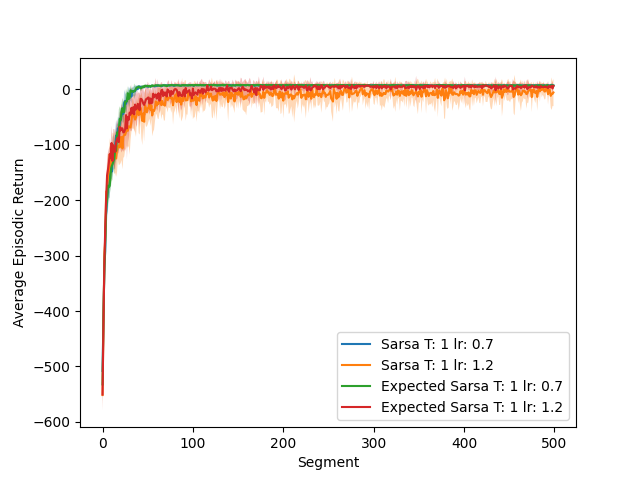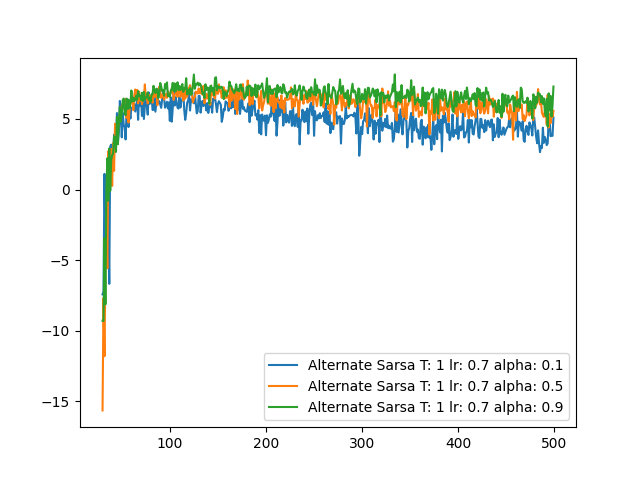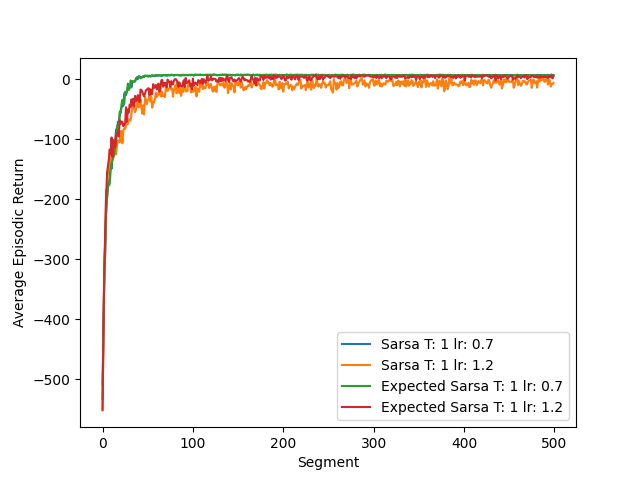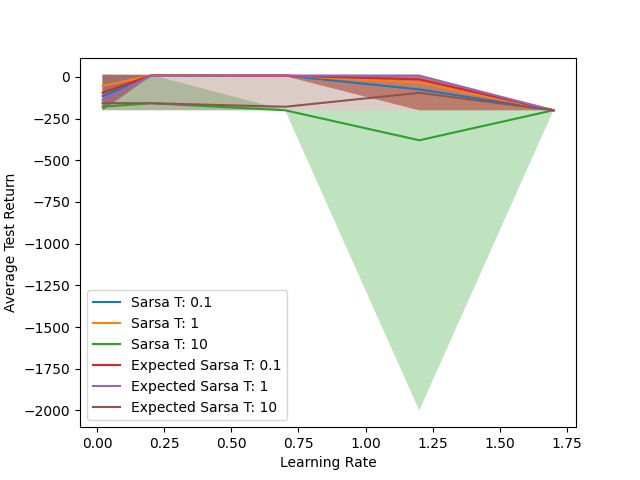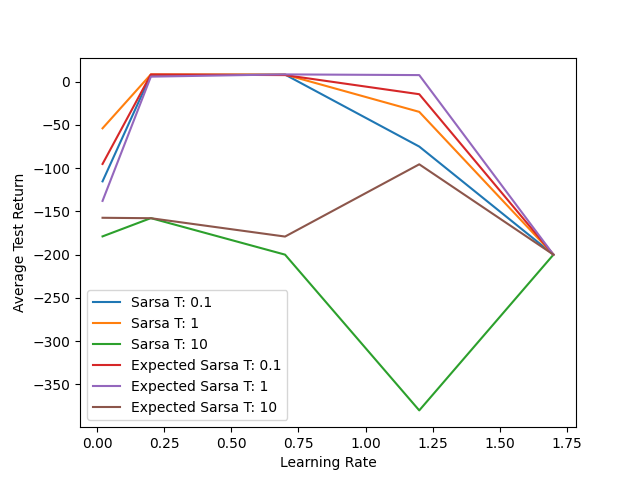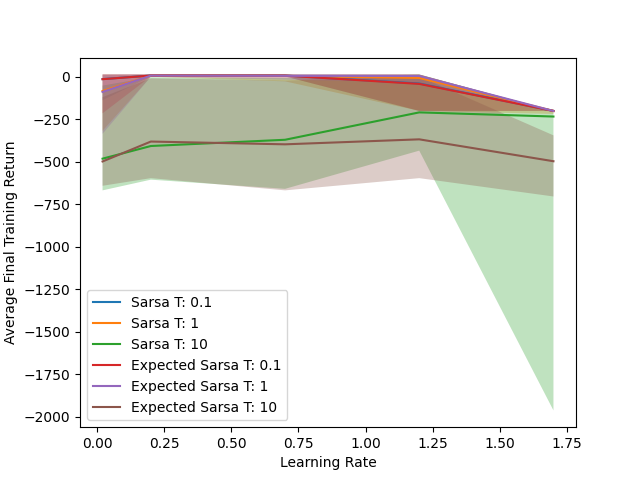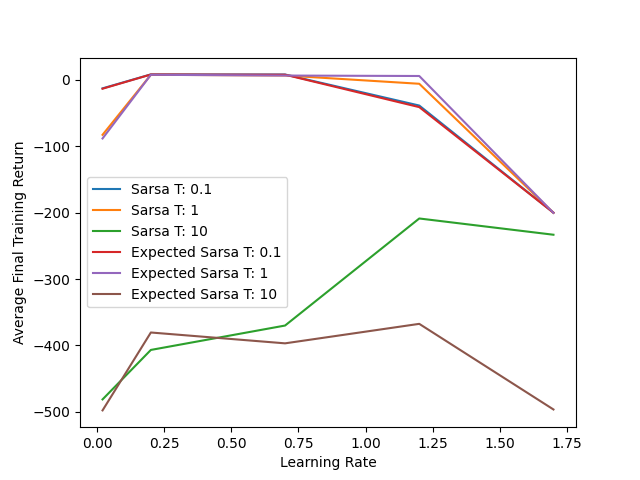